In [1]:
import os
from os import path
import pandas as pd
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection as sk

In [2]:
from keras import backend as K
from keras import losses

def OCC_loss(y_true, y_pred):
    weights = K.cast(K.abs(K.argmax(y_true, axis=1) - K.argmax(y_pred, axis=1))/(K.int_shape(y_pred)[1] - 1), dtype='float32')
    return (1.0 + weights) * losses.categorical_crossentropy(y_true, y_pred)

In [3]:
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    new_var = this_array.copy()
    rat = (this_max - this_min)/(new_var.max() - new_var.min())
    new_var = new_var * rat
    new_var -= new_var.min()
    new_var += this_min
    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [4]:
import os
print('Get current working directory : ', os.getcwd())

Get current working directory :  /Users/amalalmansour/Desktop/New_Images


In [5]:
Rad = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/machine_ratings/Radiologists_ratings.csv')
len(Rad)

2687

In [6]:
data = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/Agreement_Binary_Rating.csv')
len(data)

1332

In [7]:
df = pd.merge(data[['noduleID','InstanceID']], Rad)
display(df)

,noduleID,InstanceID,Malignancy_1,Malignancy_2,Malignancy_3,Malignancy_4
0,1,4,5,5,5,4
1,5,118,4,5,3,2
2,3,134,5,5,3,4
3,4,143,4,4,3,2
4,6,175,2,1,1,1
...,...,...,...,...,...,...
1327,2655,40771,0,2,3,2
1328,2657,40780,3,5,5,5
1329,2656,40794,2,5,5,5
1330,2658,40801,4,3,4,3


In [8]:
## Just To check how many four ratings we have in Spiculation##
## four rating = 826, three rating 506, Total = 1332
'''
test1 = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/Agreement_Binary_Rating.csv')
print(len(test1))
test2 = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/LIDC_Spiculation_IH.csv')
print(len(test2))
dft = pd.merge(test2['noduleID'], test1['noduleID'])
print(len(dft))
'''

"\ntest1 = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/Agreement_Binary_Rating.csv')\nprint(len(test1))\ntest2 = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/LIDC_Spiculation_IH.csv')\nprint(len(test2))\ndft = pd.merge(test2['noduleID'], test1['noduleID'])\nprint(len(dft))\n"

In [9]:
df.Malignancy_1.value_counts()

3    398
2    288
4    193
1    183
5    144
0    126
Name: Malignancy_1, dtype: int64

In [10]:
df.Malignancy_2.value_counts()

3    519
4    213
2    189
1    175
5    158
0     78
Name: Malignancy_2, dtype: int64

In [11]:
df.Malignancy_3.value_counts()

3    522
4    219
5    180
1    163
0    126
2    122
Name: Malignancy_3, dtype: int64

In [12]:
df.Malignancy_4.value_counts()

2    407
3    329
1    181
0    176
4    175
5     64
Name: Malignancy_4, dtype: int64

In [13]:
train = df.loc[df["Malignancy_4"] != 0 ]
print(train)

      noduleID  InstanceID  Malignancy_1  Malignancy_2  Malignancy_3  \
0            1           4             5             5             5   
1            5         118             4             5             3   
2            3         134             5             5             3   
3            4         143             4             4             3   
4            6         175             2             1             1   
...        ...         ...           ...           ...           ...   
1327      2655       40771             0             2             3   
1328      2657       40780             3             5             5   
1329      2656       40794             2             5             5   
1330      2658       40801             4             3             4   
1331      2660       40860             2             2             2   

      Malignancy_4  
0                4  
1                2  
2                4  
3                2  
4                1  
...      

In [14]:
training_data = train.sample(frac=0.8)
testing_data = train.drop(training_data.index)

In [15]:
#training_data.to_csv('/Users/amalalmansour/Desktop/New_Images/Spiculation/training_2class.csv')
#testing_data.to_csv('/Users/amalalmansour/Desktop/New_Images/Spiculation/test_2class.csv')

In [16]:
print("training_data:",len(training_data))
print("testing_data:",len(testing_data))

training_data: 925
testing_data: 231


In [17]:
train_nodIds = np.array(training_data['noduleID'])
test_nodIds = np.array(testing_data['noduleID'])

In [18]:
# collect all images for training
image_folder = '/Users/amalalmansour/Desktop/images_1332'
train_images = []
test_images = []
all_images = []
train_noduleId = []
test_noduleId = []
all_noduleId = []
print(image_folder)
file_lst = []
for dir1 in os.listdir(image_folder):
    print(dir1)
    if not dir1.startswith('.'):
        for file in os.listdir(os.path.join(image_folder, dir1)):
            #print(file)
            file_lst.append(file)
            noduleID = file.split('.')[0]
            if not file.startswith('.'):
                noduleID = int(noduleID)
                if noduleID in train_nodIds:
                    train_noduleId.append(noduleID)
                    temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                    temp_image = getNormed(temp_image)
                    #enlarged_img = getSamePadding(temp_image)
                    train_images.append(temp_image)
                    all_noduleId.append(noduleID)
                    all_images.append(temp_image)
        
                if noduleID in test_nodIds:
                    test_noduleId.append(noduleID)
                    temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                    temp_image = getNormed(temp_image)
                    test_images.append(temp_image)
                    all_noduleId.append(noduleID)
                    all_images.append(temp_image)

/Users/amalalmansour/Desktop/images_1332
.DS_Store
Malignancy_2
Malignancy_5
Malignancy_4
Malignancy_3
Malignancy_1


In [19]:
print("train_images:",len(train_images))
#print("val_images:",len(val_images))
print("test_images:",len(test_images))
print("all_images:",len(all_images))

train_images: 925
test_images: 231
all_images: 1156


In [20]:
tr_df = pd.DataFrame(train_noduleId,columns =['noduleID'])
print(tr_df)

     noduleID
0        2412
1        2374
2         471
3        1907
4        1252
..        ...
920       440
921       643
922       904
923      2594
924      2219

[925 rows x 1 columns]


In [21]:
train_slices = pd.merge(tr_df, training_data)
display(train_slices)

,noduleID,InstanceID,Malignancy_1,Malignancy_2,Malignancy_3,Malignancy_4
0,2412,36785,2,2,4,2
1,2374,36253,2,1,3,2
2,471,6853,2,3,4,2
3,1907,29039,2,1,4,2
4,1252,18823,3,2,4,2
...,...,...,...,...,...,...
920,440,6517,1,1,1,1
921,643,9251,1,1,1,1
922,904,13301,1,1,0,1
923,2594,39806,1,1,1,1


In [22]:
te_df = pd.DataFrame(test_noduleId,columns =['noduleID'])
print(te_df)

     noduleID
0        1084
1        2564
2         933
3        1097
4        1718
..        ...
226      1698
227      2346
228       126
229       657
230      2609

[231 rows x 1 columns]


In [23]:
test_slices = pd.merge(te_df, testing_data)
display(test_slices)

,noduleID,InstanceID,Malignancy_1,Malignancy_2,Malignancy_3,Malignancy_4
0,1084,15915,2,3,0,2
1,2564,39328,2,2,4,2
2,933,13642,2,0,3,2
3,1097,16112,4,2,0,2
4,1718,25766,2,1,3,2
...,...,...,...,...,...,...
226,1698,25416,1,1,1,1
227,2346,35817,4,1,1,1
228,126,1568,3,1,1,1
229,657,9498,2,1,3,1


In [24]:
test_slices.Malignancy_4.value_counts()

2    89
3    56
1    39
4    30
5    17
Name: Malignancy_4, dtype: int64

In [25]:
x_train, x_val, y_train, y_val = sk.train_test_split(train_images,train_slices['Malignancy_4'],test_size=0.2, shuffle=True)

In [26]:
x_test = test_images
y_test = test_slices['Malignancy_4']

In [27]:
y_train.value_counts()

2    253
3    221
4    115
1    112
5     39
Name: Malignancy_4, dtype: int64

In [28]:
y_val.value_counts()

2    65
3    52
1    30
4    30
5     8
Name: Malignancy_4, dtype: int64

In [29]:
y_test.value_counts()

2    89
3    56
1    39
4    30
5    17
Name: Malignancy_4, dtype: int64

In [30]:
train_images = np.array(x_train)
print(len(train_images))
val_images = np.array(x_val)
print(len(val_images))
test_images = np.array(x_test)
print(len(test_images))

740
185
231


In [31]:
# Reshape the data so the pixel vectors turn into arrays, and so the instance id's are also arrays
train_data = train_images.reshape(train_images.shape[0],71,71,1)  
#train_ids = np.array(y_train)
val_data = val_images.reshape(val_images.shape[0],71,71,1)  
#val_ids = np.array(y_val)
test_data = test_images.reshape(test_images.shape[0], 71, 71,1)
#test_ids = np.array(y_test)

In [32]:
train_ids = [int(numeric_string) for numeric_string in y_train]
val_ids = [int(numeric_string) for numeric_string in y_val]
test_ids = [int(numeric_string) for numeric_string in y_test]

In [33]:
'''
train_ids = [int(numeric_string) for numeric_string in train_ids]
train_ids = np.array(train_ids)
val_ids = [int(numeric_string) for numeric_string in val_ids]
val_ids = np.array(val_ids)
test_ids = [int(numeric_string) for numeric_string in test_ids]
test_ids = np.array(test_ids)
'''

'\ntrain_ids = [int(numeric_string) for numeric_string in train_ids]\ntrain_ids = np.array(train_ids)\nval_ids = [int(numeric_string) for numeric_string in val_ids]\nval_ids = np.array(val_ids)\ntest_ids = [int(numeric_string) for numeric_string in test_ids]\ntest_ids = np.array(test_ids)\n'

In [34]:
len(val_ids)

185

In [35]:
train_ids = keras.utils.to_categorical(train_ids, num_classes=6)
val_ids = keras.utils.to_categorical(val_ids, num_classes=6)
test_ids = keras.utils.to_categorical(test_ids, num_classes=6)
train_ids = train_ids[:,1:]
val_ids = val_ids[:,1:]
test_ids = test_ids[:,1:]

In [36]:
print(train_ids)

[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [37]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(71, 71, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.add(layers.Flatten())
model.output_shape

(None, 65536)

In [40]:
model.add(layers.Dense(5,activation='softmax'))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 5)                 327685    
                                                                 
Total params: 346,501
Trainable params: 346,501
Non-trainable params: 0
__________________________________________________

In [42]:
class EvaluateEpochEnd(tf.keras.callbacks.Callback):
    
    def __init__(self, test_data):
        self.test_data = test_data
        self.acc_scores_lst = []
        self.loss_scores_lst = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        scores = self.model.evaluate(x, y, verbose=False)
        print('\nTesting loss: {}, accuracy: {}\n'.format(scores[0], scores[1]))
        self.acc_scores_lst.append(scores[1])
        self.loss_scores_lst.append(scores[0])

In [43]:
# Compile the model
model.compile(loss= OCC_loss, #tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
test_accuracy = EvaluateEpochEnd((test_data,  test_ids))
history = model.fit(train_data, train_ids, epochs=50
                    , validation_data=(val_data, val_ids), callbacks=[test_accuracy])

Epoch 1/50
22/24 [==========================>...] - ETA: 0s - loss: 48.6498 - accuracy: 0.2812
Testing loss: 1.9101203680038452, accuracy: 0.3549783527851105

24/24 [==============================] - 1s 25ms/step - loss: 46.3794 - accuracy: 0.2838 - val_loss: 1.9458 - val_accuracy: 0.3459
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 1.3316 - accuracy: 0.5851
Testing loss: 2.0976784229278564, accuracy: 0.3722943663597107

24/24 [==============================] - 0s 19ms/step - loss: 1.3316 - accuracy: 0.5851 - val_loss: 1.8949 - val_accuracy: 0.4054
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.5543 - accuracy: 0.8459
Testing loss: 2.7773635387420654, accuracy: 0.43290042877197266

24/24 [==============================] - 1s 21ms/step - loss: 0.5543 - accuracy: 0.8459 - val_loss: 2.5249 - val_accuracy: 0.3838
Epoch 4/50
21/24 [=========================>....] - ETA: 0s - loss: 0.2069 - accuracy: 0.9539
Testing loss: 3.30430006980896, accurac

In [44]:
#model.save("/Users/amalalmansour/Desktop/New_Images/Spiculation/Rad4_Machine")

In [45]:
test_acc = test_accuracy.acc_scores_lst
test_loss = test_accuracy.loss_scores_lst

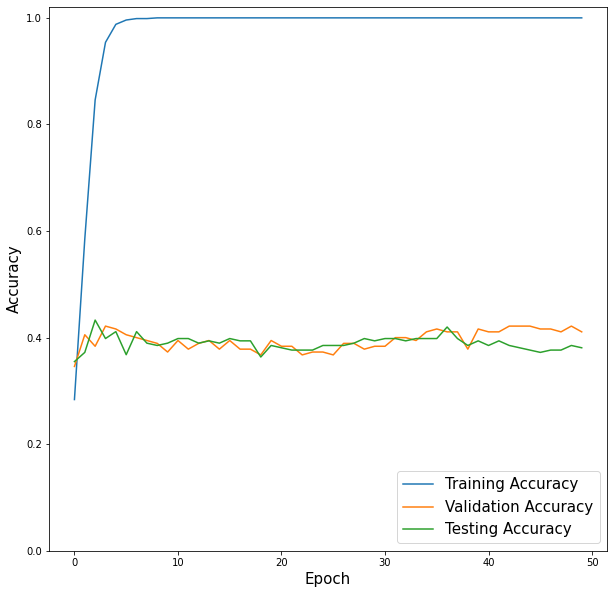

In [46]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.plot(test_acc, label = 'Testing Accuracy')
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim([0.0, 1.02])
plt.legend(loc='lower right', prop={'size': 15})

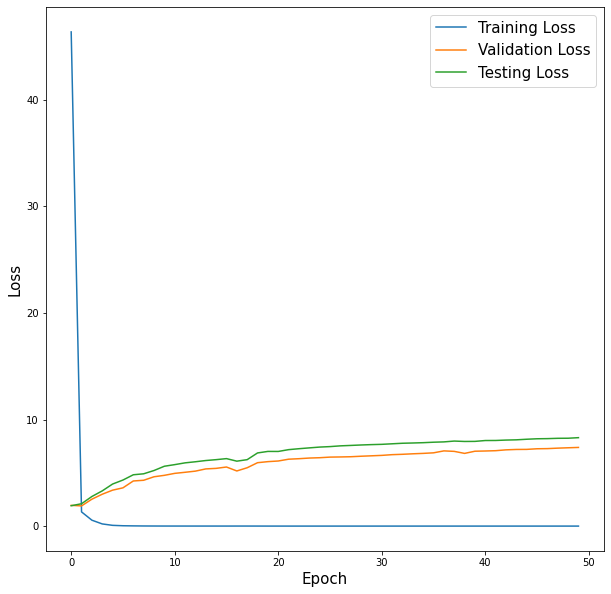

In [47]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.plot(test_loss, label = 'Testing Loss')
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
#plt.ylim([0.0, 1.02])
plt.legend(loc='upper right', prop={'size': 15})

In [48]:
test_loss, test_acc = model.evaluate(test_data,  test_ids, verbose=2)

8/8 - 0s - loss: 8.2987 - accuracy: 0.3810 - 74ms/epoch - 9ms/step


In [49]:
test_acc

0.380952388048172

In [50]:
predictions = model.predict(test_data)

In [51]:
#y_pred = (predictions > 0.5)

In [52]:
print(model.evaluate(test_data,  test_ids, verbose=2))

8/8 - 0s - loss: 8.2987 - accuracy: 0.3810 - 65ms/epoch - 8ms/step
[8.29872989654541, 0.380952388048172]


In [53]:
y_preds_multiclass = predictions.argmax(axis=1)

In [54]:
y_preds_multiclass

array([2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2, 3, 0, 2, 1, 2, 1, 1, 2, 1, 1,
       2, 2, 1, 1, 3, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 3, 1, 4, 3, 3, 1, 2,
       1, 4, 2, 3, 1, 2, 1, 1, 2, 2, 2, 3, 1, 2, 3, 1, 3, 1, 3, 3, 2, 1,
       2, 1, 4, 3, 3, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 2, 1,
       2, 1, 0, 2, 2, 3, 2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 3, 3, 1, 1, 1, 1,
       3, 1, 2, 3, 1, 1, 3, 2, 2, 0, 2, 3, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2,
       2, 2, 2, 0, 1, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2,
       2, 1, 2, 2, 2, 1, 3, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1,
       1, 2, 1, 3, 1, 3, 1, 1, 3, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2])

In [55]:
l = y_preds_multiclass.tolist()
l1 = [5 if x == 4 else x for x in l]
l2 = [4 if x == 3 else x for x in l1]
l3 = [3 if x == 2 else x for x in l2]
l4 = [2 if x == 1 else x for x in l3]
l5 = [1 if x == 0 else x for x in l4]
y_preds_multiclass = np.array(l5)

In [56]:
tr_predictions = model.predict(train_data)
y_tr_preds_multiclass = tr_predictions.argmax(axis=1)

In [57]:
l = y_tr_preds_multiclass.tolist()
l1 = [5 if x == 4 else x for x in l]
l2 = [4 if x == 3 else x for x in l1]
l3 = [3 if x == 2 else x for x in l2]
l4 = [2 if x == 1 else x for x in l3]
l5 = [1 if x == 0 else x for x in l4]
y_tr_preds_multiclass = np.array(l5)

In [58]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_preds_multiclass))
print(confusion_matrix(y_train, y_tr_preds_multiclass))

[[25  5  9  0  0]
 [ 7 37 37  8  0]
 [ 5 23 20  7  1]
 [ 3 10 11  5  1]
 [ 0  5  4  7  1]]
[[112   0   0   0   0]
 [  0 253   0   0   0]
 [  0   0 221   0   0]
 [  0   0   0 115   0]
 [  0   0   0   0  39]]


In [59]:
all_images = np.array(all_images)
all_data = all_images.reshape(all_images.shape[0],71,71,1)  
all_ids = np.array(all_noduleId)

In [60]:
all_predictions = model.predict(all_data)
y = all_predictions.argmax(axis=1)

In [61]:
l = y.tolist()
l1 = [5 if x == 4 else x for x in l]
l2 = [4 if x == 3 else x for x in l1]
l3 = [3 if x == 2 else x for x in l2]
l4 = [2 if x == 1 else x for x in l3]
l5 = [1 if x == 0 else x for x in l4]

In [62]:
data = {'noduleID': all_noduleId,
        'pred_ratings': l5}

In [63]:
all_df = pd.DataFrame(data)
all_df

,noduleID,pred_ratings
0,1084,3
1,2412,2
2,2374,2
3,471,2
4,1907,2
...,...,...
1151,657,3
1152,2609,3
1153,904,1
1154,2594,1


In [64]:
all_df.pred_ratings.value_counts()

2    413
3    358
1    181
4    159
5     45
Name: pred_ratings, dtype: int64

In [65]:
all_df.to_csv("/Users/amalalmansour/Desktop/New_Images/Malignancy/OCC_machine4.csv")